In [53]:
import torch as th
from torch.utils.data import Dataset
from torch import nn

from torchvision import transforms

from ConvLSTM_model import ConvLSTM_Model
from utils import SequenceDataset, SSIM_MSE_Loss

import pandas as pd
import os

from IPython.display import Image

In [54]:
# define a dataset

id_data = pd.read_csv('../data/id_df_final.csv')

seq_len = id_data.groupby('sequence').size()
seq_len = seq_len.to_dict()
seq_rain = id_data.groupby('sequence')['rain_category'].mean()
seq_rain = seq_rain.to_dict()

seq_df = pd.DataFrame({'seq_len': seq_len, 'seq_rain': seq_rain})

# split the sequences in train and test set (80/20)
train_seq = seq_df.sample(frac=0.8, random_state=1)
test_seq = seq_df.drop(train_seq.index)

print(train_seq['seq_len'].mean(), test_seq['seq_len'].mean())
print(train_seq['seq_len'].std(), test_seq['seq_len'].std())
print(train_seq['seq_rain'].mean(), test_seq['seq_rain'].mean())
print(train_seq['seq_rain'].std(), test_seq['seq_rain'].std())

# get the sequences of the train and test set
train_seq_idx = train_seq.index
test_seq_idx = test_seq.index

train_data = id_data[id_data['sequence'].isin(train_seq_idx)]
train_data.shape

test_data = id_data[id_data['sequence'].isin(test_seq_idx)]
test_data.shape


115.44067796610169 118.83333333333333
110.87395957733693 86.95027644989202
2.150042010724777 2.116623367448169
0.8743386816727606 0.9540785561831368


(3565, 5)

In [55]:
id_data = None
seq_len = None
seq_rain = None
seq_df = None
train_seq = None
test_seq = None
train_seq_idx = None
test_seq_idx = None

In [56]:
# model
filter_size = 5
stride = 1
patch_size = 2
layer_norm = 0

num_hidden = [16, 8, 8, 16]
num_layers = len(num_hidden)

custom_model_config = {
    'in_shape': [1, 128, 128], # T, C, H, W
    'patch_size': 1,
    'filter_size': 3, # given to ConvLSTMCell, kernel size
    'stride': 2, # given to ConvLSTMCell
    'layer_norm' : False, # given to ConvLSTMCell
    # the sum of pre_seq_length and aft_seq_length has to be = len(inputs)
    'reverse_scheduled_sampling': 0
}

if th.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

device = th.device("cuda" if th.cuda.is_available() else "cpu")
th.cuda.empty_cache()

# Instantiate the model
# Assuming x_train shape is (batch_size, sequence_length, channels, height, width)
model = ConvLSTM_Model(num_layers, num_hidden, custom_model_config, schedule_sampling=False)
model = nn.DataParallel(model)
model.to(device)
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = th.optim.Adam(model.parameters())

CUDA is not available.


In [57]:
images = ['tensor_2453267.pt',
 'tensor_2453247.pt',
 'tensor_2453227.pt',
 'tensor_2453209.pt',
 'tensor_2453187.pt',
 'tensor_2453147.pt',
 'tensor_2453127.pt',
 'tensor_2453107.pt',
 'tensor_2453087.pt',
 'tensor_2453067.pt']

In [58]:
# Loop over the dataset multiple times, with different sequence lengths to avoid the vanishing gradient problem
input_row = images[0:5]
output_row = images[5:]

inputs = [th.load(f"../data/images/{image}") for image in input_row]
targets = [th.load(f"../data/images/{image}") for image in output_row]
inputs = th.stack(inputs, dim=0)
targets = th.stack(targets, dim=0)
inputs = inputs.unsqueeze(0)  # Shape: [1, 5, 1, 128, 128]
targets = targets.unsqueeze(0)

/var/folders/tp/vfdk9pcj66g2trgt19fh08480000gn/T/ipykernel_15163/3104026855.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inputs = [th.load(f"../data/images/{image}") 

In [59]:
for seq_len in range(1, 6):

    print(f"Training with sequence length {seq_len}")
    
    # Training loop
    num_epochs = 10  # Set the number of epochs
    # Lists to keep track of the losses for each epoch
    train_losses = []
    test_losses = []

    for epoch in range(seq_len*num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()
        outputs = model(inputs[:,0:seq_len], th.ones_like(inputs[:,0:seq_len]), schedule_sampling=False)
        loss = criterion(outputs, targets[:,0:seq_len])
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{seq_len*num_epochs}], Loss: {loss.item():.4f}")


print("Training complete!")

Training with sequence length 1
Epoch [1/10], Loss: 0.2294
Epoch [2/10], Loss: 0.2294
Epoch [3/10], Loss: 0.2294
Epoch [4/10], Loss: 0.2294
Epoch [5/10], Loss: 0.2294
Epoch [6/10], Loss: 0.2294
Epoch [7/10], Loss: 0.2294
Epoch [8/10], Loss: 0.2294
Epoch [9/10], Loss: 0.2293
Epoch [10/10], Loss: 0.2293
Training with sequence length 2
Epoch [1/20], Loss: 0.2289
Epoch [2/20], Loss: 0.2288
Epoch [3/20], Loss: 0.2286
Epoch [4/20], Loss: 0.2284
Epoch [5/20], Loss: 0.2281
Epoch [6/20], Loss: 0.2277
Epoch [7/20], Loss: 0.2272
Epoch [8/20], Loss: 0.2265
Epoch [9/20], Loss: 0.2257
Epoch [10/20], Loss: 0.2246
Epoch [11/20], Loss: 0.2231
Epoch [12/20], Loss: 0.2213
Epoch [13/20], Loss: 0.2190
Epoch [14/20], Loss: 0.2160
Epoch [15/20], Loss: 0.2124
Epoch [16/20], Loss: 0.2078
Epoch [17/20], Loss: 0.2021
Epoch [18/20], Loss: 0.1952
Epoch [19/20], Loss: 0.1870
Epoch [20/20], Loss: 0.1772
Training with sequence length 3
Epoch [1/30], Loss: 0.0708
Epoch [2/30], Loss: 0.0724
Epoch [3/30], Loss: 0.0732
E

In [60]:
input_pil_frames = [transforms.ToPILImage()(frame) for frame in inputs[0]]
true_pil_frames = [transforms.ToPILImage()(frame) for frame in targets[0]]

true_gif_list = input_pil_frames + true_pil_frames
true_gif_list[0].save('true.gif', save_all=True, append_images=true_gif_list[1:], duration=1000, loop=5)

predicted_frames = model(inputs, mask_true=th.ones_like(inputs))
predicted_frames = predicted_frames.squeeze(0)
predicted_pil_frames = [transforms.ToPILImage()(frame) for frame in predicted_frames]
pred_gif_list = input_pil_frames + predicted_pil_frames

# List of frames as PIL Image objects
# Duration sets the display time for each frame in milliseconds
# Loop sets the number of loops. Default is 0 and means infinite

pred_gif_list[0].save('pred.gif', save_all=True, append_images=pred_gif_list[1:], duration=1000, loop=5)

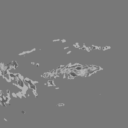

In [61]:
Image(filename='pred.gif')

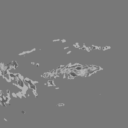

In [62]:
Image(filename='true.gif')

In [63]:
transposed_inputs = inputs[0].transpose(-2, -1)
transposed_targets = targets[0].transpose(-2, -1)

input_pil_frames = [transforms.ToPILImage()(frame) for frame in transposed_inputs]
true_pil_frames = [transforms.ToPILImage()(frame) for frame in transposed_targets]

true_gif_list = input_pil_frames + true_pil_frames
true_gif_list[0].save('true.gif', save_all=True, append_images=true_gif_list[1:], duration=1000, loop=5)

predicted_frames = model(inputs, mask_true=th.ones_like(inputs))
predicted_frames = predicted_frames.squeeze(0)
predicted_pil_frames = [transforms.ToPILImage()(frame) for frame in predicted_frames]
pred_gif_list = input_pil_frames + predicted_pil_frames

# List of frames as PIL Image objects
# Duration sets the display time for each frame in milliseconds
# Loop sets the number of loops. Default is 0 and means infinite

pred_gif_list[0].save('pred.gif', save_all=True, append_images=pred_gif_list[1:], duration=1000, loop=5)

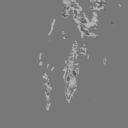

In [64]:
Image(filename='pred.gif')

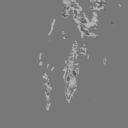

In [65]:
Image(filename='true.gif')